(sec:feature-extraction)=
# 特徴量抽出

In [1]:
"""
下準備のコード
"""

import os
import sys
import random
import warnings

import numpy as np
import seaborn as sns
import matplotlib
from myst_nb import glue
from tqdm.notebook import tqdm
from sklearn.exceptions import ConvergenceWarning

# 実験に使うデータ数
n_samples = 2000
glue("n_samples", n_samples, display=False)

# 一部の警告を無視
warnings.simplefilter("ignore", ConvergenceWarning)

# シードの固定
random.seed(31415)
np.random.seed(31415)

# グラフの設定
matplotlib.rcParams["figure.dpi"] = 150
sns.set(style="white", palette="colorblind")

さて、今回からは数字ではなく「ひらがな」のデータセットを用いて、より複雑な識別問題に取り組む。

データセットは国立国会図書館の[NDLラボ](https://lab.ndl.go.jp/)が公開している文字画像データセットを使用する。

- 文字画像データセット: <https://github.com/ndl-lab/hiragana_mojigazo>

実際のデータセットは、以下のURLにホストされているので、ここからダウンロードする。

**文字画像データセット(平仮名73文字版) (zip形式)** 

- <http://lab.ndl.go.jp/dataset/hiragana73.zip>

In [2]:
"""
平仮名73文字データセットの準備
"""

import zipfile

import requests

url = "http://lab.ndl.go.jp/dataset/hiragana73.zip"
filename = os.path.basename(url)

# HTTPリクエストを送ってデータサイズを取得
r = requests.get(url, stream=True)
total_size = int(r.headers.get("content-length", 0))
chunk_size = 65535

# 実際のファイルのダウンロード
pbar = tqdm(total=total_size, unit="B", unit_scale=True)
with open(filename, "wb") as f:
    for data in r.iter_content(chunk_size):
        f.write(data)
        pbar.update(chunk_size)

# ダウンロードが完了したらZIPを展開する
with zipfile.ZipFile(filename, "r") as f:
    f.extractall()

  0%|          | 0.00/233M [00:00<?, ?B/s]

## データセットの前処理

このデータセットは濁音、半濁音を含むひらがな73文字に対して、そのUnicode値のフォルダの中に、48×48の画像がPNG形式で保存されている。

各ひらがなのUnicode値を調べるには、`ord`関数を用いてUnicode値に変換した後に、それを`hex`関数を用いて16進数表記の文字列に変換すれば良い。

一例として「あ」であれば、以下のようにUnicode値を得ることができる。

In [3]:
a = "あ"
hira_a = hex(ord(a))
print(hira_a)

0x3042


逆に、あいうえお順で文字を取得したければ、「あ」に対応するUnicode値である`0x3042`からスタートして、1ずつ値を上げていきながら、その数字を`chr`関数を用いて文字に変換すれば良い。

なお、16進数の文字列を整数に直したいときには、`int(hira_a)`と単に文字列を渡すだけではダメで、第2引数に何進数の数字なのかを与えて `int(hira_a, 16)` のようにする必要があることに注意すること。

上記のひらがなデータセットは「ゃ」や「っ」などの小文字を含まない73文字から構成されているが、「あ」から「ん」までは、小文字を含め82文字なので、これを列挙してみる。

In [4]:
for i in range(82):
    print(chr(int(hira_a, 16) + i), end="")

あぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもゃやゅゆょよらりるれろゎわゐゑをん

ひらがなデータセットのフォルダ名は16進数を表わす`0x`の代わりに`U`が接頭辞になっているので、フォルダ名の`U`を`0x`に置換して、どの文字がデータセットに含まれているかをチェックしてみる。

In [5]:
# サブフォルダの数を調べる
dirname = "hiragana73"
folders = sorted([d for d in os.listdir(dirname)])
print('There are {:d} folders in "{:s}".'.format(len(folders), dirname))

# フォルダに対応する文字を列挙
for d in folders:
    x = d.replace("U", "0x")
    print(chr(int(x, 16)), end="")

There are 73 folders in "hiragana73".
あいうえおかがきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよらりるれろわゐゑをん

さらに、各文字に何個ずつ画像が含まれているかもチェックしておこう。

In [6]:
import numpy as np
import pandas as pd
from IPython import display

chars = [chr(int(d.replace("U", "0x"), 16)) for d in folders]
dir_paths = [os.path.join(dirname, d) for d in folders]
num_images = [len(os.listdir(d)) for d in dir_paths]

df = pd.DataFrame([(c, n) for c, n in zip(chars, num_images)])
sub_dfs = [df[i : i + 10].reset_index(drop=True) for i in range(0, len(df.index), 10)]
df = pd.concat(sub_dfs, axis=1).fillna("")

df.index = [i for i in range(len(df.index))]
df.columns = [j for j in range(len(df.columns))]


def custom_style(df):
    index = df.index
    columns = df.columns
    styles = []
    for i in range(len(index)):
        s = []
        for j in range(len(columns)):
            if columns[j] % 2 == 0:
                s.append("font-weight: bold;")
            else:
                s.append(None)
        styles.append(s)

    return np.array(styles, dtype="object")


df.style.format(precision=0).format_index("", axis=1).format_index("", axis=0).apply(
    custom_style, axis=None
)

,,,,,,,,,,,,,,,,
,あ,1208,ぐ,1043,ず,1046,づ,1080,は,1247,べ,1109,や,1285,ゑ,1030
,い,1122,け,1155,せ,1165,て,1213,ば,1105,ぺ,268,ゆ,1282,を,1254
,う,1148,げ,1058,ぜ,1115,で,1178,ぱ,262,ほ,1115,よ,1166,ん,1285
,え,1077,こ,1115,そ,1285,と,1184,ひ,1074,ぼ,1044,ら,1114,,
,お,1283,ご,1078,ぞ,1066,ど,1134,び,1045,ぽ,261,り,1244,,
,か,1259,さ,1261,た,1285,な,1233,ぴ,126,ま,1285,る,1190,,
,が,1200,ざ,1070,だ,1116,に,1260,ふ,1285,み,1142,れ,1238,,
,き,1121,し,1285,ち,1052,ぬ,1093,ぶ,1149,む,1058,ろ,1069,,
,ぎ,1091,じ,1099,ぢ,1132,ね,1126,ぷ,112,め,1233,わ,1283,,
,く,1266,す,1282,つ,1142,の,1160,へ,1114,も,1187,ゐ,1053,,


このように、ひらがなについて、おおよそ1000程度の画像が含まれていることが確認できる。なお、半濁音のひらがなは全体的に少なめで100-200程度となっている。

### 分類用のデータ加工

MNISTでは手書き文字の画像が28x28=576次元ベクトル、ラベルが10種類の数字のいずれかを表わす0-9の数字であった。

このようなデータ形式をひらがなデータセットに対しても作成しておく。なお、今回は分類の難易度を上げるため、**画像をランダムに回転したり、拡大縮小したりして、データのばらつきを大きくしておく**。また、今回のデータセットは画像が一度JPEGで圧縮されているようで、ブロックノイズを多く含むため、最初にバイラテラル・フィルタを書けてノイズを低減しておく。

In [7]:
# 文字への整数の割り当て
n_chars = len(chars)
char2num = {c: i for i, c in enumerate(chars)}

In [8]:
import cv2

n_total = sum(num_images)
pbar = tqdm(total=n_total)

# 画像の読み取り
X = []  # 画像データ
y = []  # ラベルデータ
for d in dir_paths:
    # 文字に対する数字を計算
    char = os.path.basename(d).replace("U", "0x")
    char = chr(int(char, 16))
    num = char2num[char]
    # 画像の読み込み
    image_files = [os.path.join(d, f) for f in os.listdir(d)]
    image_files = [f for f in image_files if f.endswith(".png")]
    for f in image_files:
        image = cv2.imread(f, cv2.IMREAD_COLOR)
        if image is None:
            raise IOError("Failed to load image: {:s}".format(f))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # データのランダム回転、ランダムスケール
        height, width = image.shape
        center = (width // 2, height // 2)
        scale = np.random.uniform(0.8, 1.1)
        angle = np.random.uniform(-90, 90)
        trans = cv2.getRotationMatrix2D(center, angle, scale)
        image = cv2.warpAffine(image, trans, (width, height), borderMode=cv2.BORDER_REPLICATE)
        image = cv2.bilateralFilter(image, -1, 15.0, 5.0)

        X.append(image.flatten())
        y.append(num)

        pbar.update(1)

  0%|          | 0/80000 [00:00<?, ?it/s]

読み込みが完了したら例のごとく訓練データとテストデータに分割しておく。今回は画像が80000枚あるので、60000枚を訓練画像、20000枚をテスト画像とする。

In [9]:
from sklearn import model_selection

X, X_test, y, y_test = model_selection.train_test_split(
    X, y, train_size=70000, test_size=10000, shuffle=True
)

X, X_val, y, y_val = model_selection.train_test_split(
    X, y, train_size=60000, test_size=10000, shuffle=True
)

X, y = X[:n_samples], y[:n_samples]
X_val, y_val = X_val[:n_samples], y_val[:n_samples]
X_test, y_test = X_test[:n_samples], y_test[:n_samples]

データセットの先頭5枚の画像は次のようになっている。

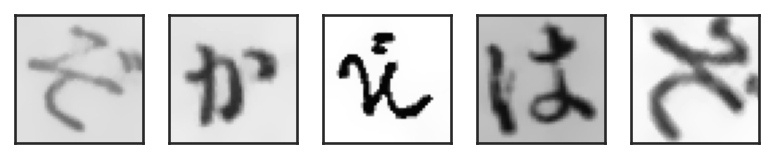

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5)
for i in range(5):
    axs[i].imshow(X[i].reshape((48, 48)), cmap="gray", vmin=0, vmax=255, interpolation=None)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

### 実験: SVMによる分類

まずは、MNISTの時と同様にscikit-learnによる分類を試してみる。この時、[scikit-learnの節](sec:scikit-learn)で紹介したように、予め入力データを正規化しておく処理である`StandardScaler`を使用する。

scikit-learnには`make_pipline`というメソッドが用意されており、このメソッドに入力データに対して行う処理を順に入れておくと、自動的に、それらを実行してくれる。今回はこれを利用する。

In [11]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svc_params = {
    "kernel": "rbf",
    "tol": 1.0e-4,
    "gamma": 0.01,
    "max_iter": 200,
}

clf = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)

clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma=0.01, max_iter=200, tol=0.0001))])

In [12]:
# 訓練時の識別精度の確認
y_pred = clf.predict(X)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Naive: acc(train)={:.2f}%".format(acc_train))

Naive: acc(train)=100.00%


In [13]:
# テストデータに対する識別精度の計算
y_pred = clf.predict(X_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Naive: acc(test)={:.2f}%".format(acc_test))

Naive: acc(test)=1.50%


このように、今回は分類問題の難易度が上がっており、SVMを用いても十分な精度が得られていないことが分かる。また、単に画像をベクトルとして扱うのは、計算効率の観点からも好ましいとは言いがたく、画像の大きさに依存しないように画像を特徴ベクトル化できることが好ましいと言える。

### 輝度によるヒストグラム化

まず、非常に単純なアイディアとして画像の輝度を基準としたヒストグラム化を考えてみる。今、画像は256階調の輝度で表わされているので、輝度のヒストグラムを作ることで、どれほど大きな画像であっても256次元のベクトルにすることができる。

一例として、データセットの先頭の画像に対して、輝度ヒストグラムを計算した結果が以下である (分かりやすさのためにヒストグラムのbin数を32としてある)。

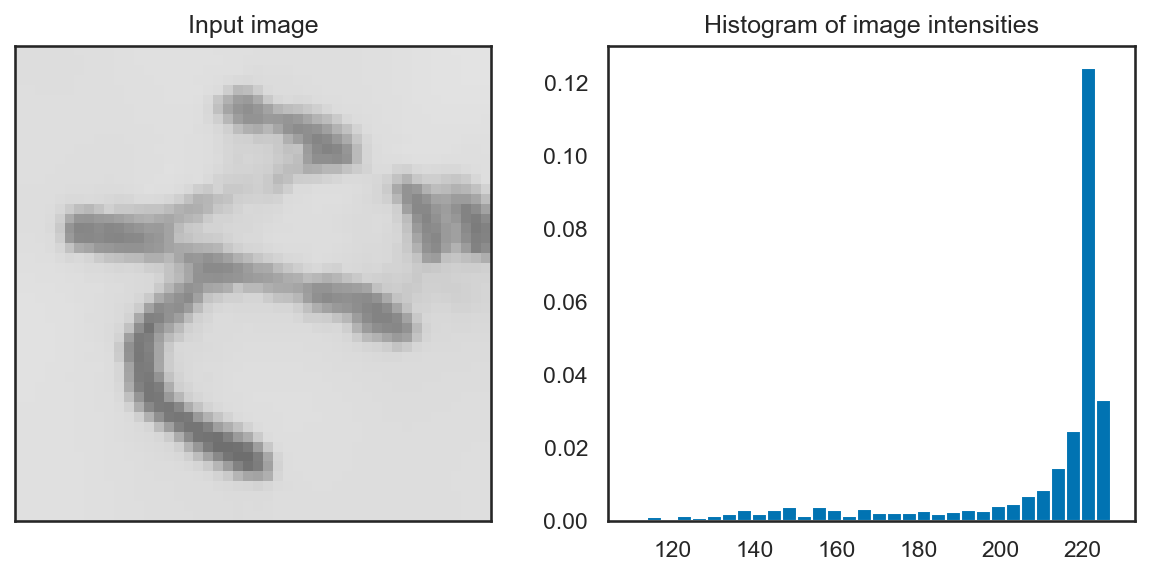

In [14]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

im = X[0].reshape((48, 48))

fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(im, cmap="gray", vmin=0, vmax=255, interpolation=None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("Input image")

ax2.hist(im.flatten(), bins=32, density=True)
ax2.set_title("Histogram of image intensities")

plt.tight_layout()
plt.show()

このヒストグラムを画像全体に対する特徴ベクトルとみなし、SVMによる文字分類を試してみる。

In [15]:
H = []
for x in tqdm(X):
    h = np.histogram(x, bins=255, density=True)
    H.append(h[0])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
clf2 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf2.fit(H, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma=0.01, max_iter=200, tol=0.0001))])

In [17]:
# 訓練時の識別精度の確認
y_pred = clf2.predict(H)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Histogram: acc(train)={:.2f}%".format(acc_train))

Histogram: acc(train)=63.45%


In [18]:
H_test = []
for x in tqdm(X_test):
    h = np.histogram(x, bins=255, density=True)
    H_test.append(h[0])

  0%|          | 0/2000 [00:00<?, ?it/s]

In [19]:
# テストデータに対する識別精度の計算
y_pred = clf2.predict(H_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Histogram: acc(test)={:.2f}%".format(acc_test))

Histogram: acc(test)=2.50%


しかし、実際に試してみると上記のように満足な精度が得られるには至っていない。これは、ほとんどの画像がほぼ同じ割合の白と黒の領域でできていて、それをヒストグラム化してしまうと、文字の分類が難しくなるためである。

また、輝度のヒストグラムは写真を写した時の周囲の明るさなどにも影響を受けるため、たとえ写真に写っている物が同じであったとしても、周囲の環境によって、ヒストグラムが変化してしまうなど、一貫性に乏しい。

従って、もう少し気の利いた方法を考える必要がある。

## Local Binary Pattern (LBP)

Local Binary Pattern (LBP)は、とある画素を中心とした3x3の領域について、中心画素と周りの画素の輝度の大小を数値化する手法である {cite}`ojala1996comparative`。

一例として、とある中心画素周辺の画素値が以下のようになっている場合を考えよう。

In [20]:
def draw_frame(problem, fig, ax):
    mask = (problem == 0).astype("float32")
    frame = []
    ax.set_xticks(np.arange(0, 9))
    ax.set_yticks(np.arange(0, 9))
    ax.set_xticklabels(np.arange(1, 10))
    ax.set_yticklabels(np.arange(1, 10))

    ax.set_xticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_yticks(np.arange(1, 10) - 0.5, minor=True)
    ax.set_xticks(np.arange(3, 10, 3) - 0.5)
    ax.set_yticks(np.arange(3, 10, 3) - 0.5)

    ims = plt.imshow(mask * 0.2, cmap="Blues", vmin=0.0, vmax=1.0)
    frame.append(ims)
    for (i, j), z in np.ndenumerate(problem):
        txt = ax.text(j, i, "{:d}".format(z), ha="center", va="center", color="k", fontsize=15)
        frame.append(txt)

    ax.grid(which="minor", color="k", linestyle="-", linewidth=0.5)
    ax.grid(which="major", color="k", linestyle="-", linewidth=1.0)

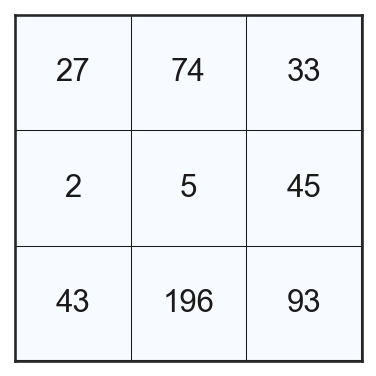

In [21]:
m = np.random.randint(0, 256, size=(3, 3))
fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(m, fig, ax)

このとき、中心画素と周囲の8画素の大小を見比べて、大きいものを1, 小さいものを0に置き換える。

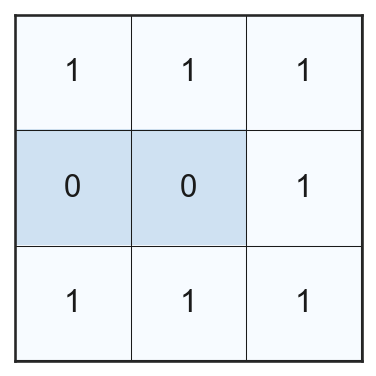

In [22]:
c = m[1, 1]
b = (m > c).astype("int32")
fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(b, fig, ax)

この周囲の8画素に割り当てられた0, 1のパターンが8ビットの符号なし整数であると考えて数値を求める。このとき、以下のような時計回りに2のべき乗が並んだ画像を用いると良い。

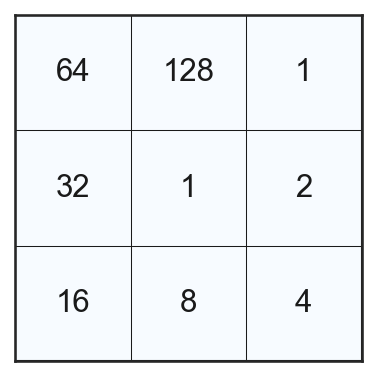

In [23]:
p = 2 ** np.array([[6, 7, 0], [5, 0, 1], [4, 3, 2]])

fig, ax = plt.subplots(figsize=(3, 3))
draw_frame(p, fig, ax)

In [24]:
from IPython.display import Markdown

Markdown(f"すると、上記の3x3の領域に対しては、LBPの値として**{np.sum(b * p):d}**が求まる")

すると、上記の3x3の領域に対しては、LBPの値として**223**が求まる

In [25]:
lbp = np.sum(b * p)
print("LBP={:d}".format(lbp))

LBP=223


この計算を先ほどと同様にデータセットの先頭画像の各画素に対して計算すると、その結果と、LBP値のヒストグラムは以下のようになる。

In [26]:
im = X[0].reshape((48, 48))

lbp = np.zeros_like(im).astype("uint8")
for j in range(1, im.shape[0] - 1):
    for i in range(1, im.shape[1] - 1):
        c = im[i, j]
        m = im[i - 1 : i + 2, j - 1 : j + 2]
        b = (m > c).astype("int32")
        lbp[i, j] = np.sum(p * b)

# 輪郭の画素では計算できないので、輪郭を除いておく
lbp = lbp[1:-1, 1:-1]

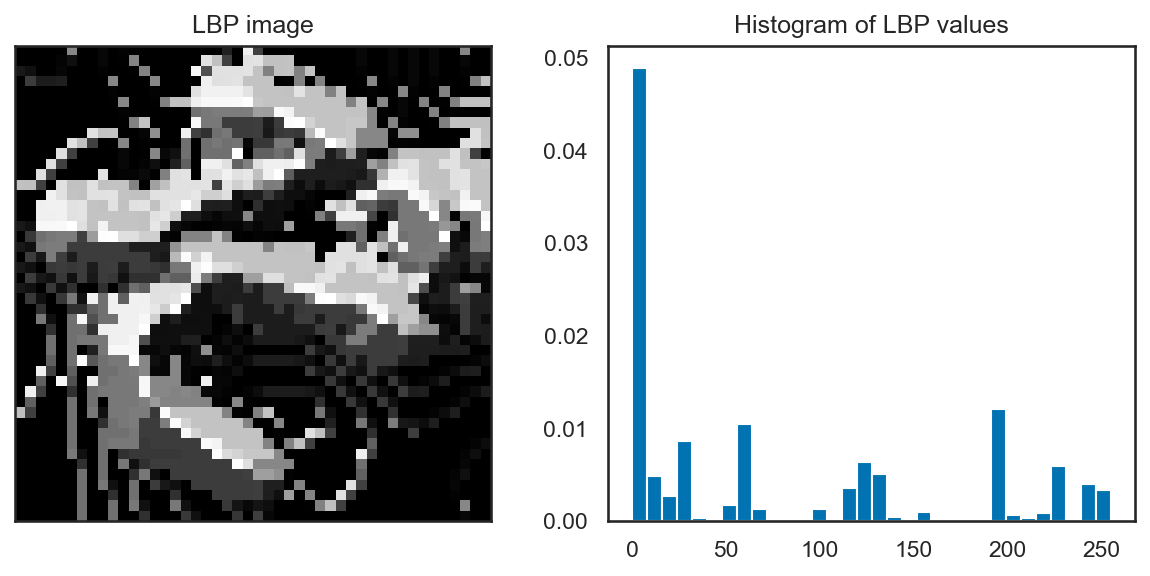

In [27]:
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(lbp, cmap="gray", vmin=0, vmax=255, interpolation=None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("LBP image")

ax2.hist(lbp.flatten(), bins=32, density=True)
ax2.set_title("Histogram of LBP values")

plt.tight_layout()
plt.show()

LBPを用いることの利点は画像の相対的な輝度だけを見ている点にあり、仮に画像の輝度が2倍になったりしても求まるLBPの値は全く変化しない。そのため、同じ対象を異なる光源下で計算した場合などに一貫した特徴を得られる。

In [28]:
from sklearn.feature_extraction.image import extract_patches_2d


def calc_lbp(x):
    pat = (2 ** np.array([[0, 1, 2], [7, 0, 3], [6, 5, 4]])).astype("int32")

    patches = extract_patches_2d(x, (3, 3))
    centers = patches[:, 1, 1].reshape((-1, 1, 1))
    binary = (patches > centers).astype("int32")

    return np.sum(binary * pat.reshape((1, 3, 3)), axis=(1, 2))


def calc_lbp_hist(x):
    lbp = calc_lbp(x)
    return np.histogram(lbp, bins=255, density=True)[0]


L = [calc_lbp_hist(x.reshape((48, 48))) for x in tqdm(X)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [29]:
clf3 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf3.fit(L, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma=0.01, max_iter=200, tol=0.0001))])

In [30]:
# 訓練時の識別精度の確認
y_pred = clf3.predict(L)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("LBP: acc(train)={:.2f}%".format(acc_train))

LBP: acc(train)=99.55%


In [31]:
L_test = [calc_lbp_hist(x.reshape((48, 48))) for x in tqdm(X_test)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [32]:
# テストデータに対する識別精度の計算
y_pred = clf3.predict(L_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("LBP: acc(test)={:.2f}%".format(acc_test))

LBP: acc(test)=6.20%


先ほどの単純な輝度ヒストグラムに比べれば、精度は改善しているものの、画像をそのまま入力したSVMには劣る結果となっている。

今、データセットに含まれるデータはひらがながランダムに回転したりスケールしたりしている。LBPは上記の計算方法からも分かるとおり、物体が回転してしまうと得られる値が変わってしまう性質がある。従って、今回のようにデータセット中でひらがながランダムに回転しているような場合には、もう少し工夫をする必要がある。

### Uniform LBP

元々のLBPが持つ回転に対して変化してしまう問題を解決した手法の一つに**Uniform LBP** {cite}`ojala2002multiresolution` がある。

Uniform LBPの基本的なアイディアは、注目画素を中心に**円状に配置された点の輝度**を調べて、その輝度の大小関係のパターン (つまり, 0, 1の列)が回転したときに一致するものを同じ物であると見なすという部分にある。

より具体的には、円状に配置された0, 1の列を1周する間に何回0から1あるいは1から0への変化が起こるかを考える。例えば、12時方向を視点として反時計回りに `(0, 0, 1, 0, 1, 1, 1, 0)` というパターンが現れたとすると、0→1 / 1→0の遷移回数は4回である。

Uniform LBPでは、この遷移回数が0回のものと2回のものを特別視する。遷移の回数が0回、ということは、全ての要素が0か1かのいずれかで2通りが考えられる。また、遷移の回数が2回、ということは、0と1が両方含まれているものの、0と1が連続して現れているようなパターンで、これは要素の数が$N$個であれば、$N-1$通りのパターンが考えられる。

以上より、遷移の回数が0回のものと2回のものの総数は$N+1$個ある。これ以外のパターンは全て同じものであると見なすと、パターンの総数は$N+2$個である。

以下ではscikit-imageの`local_binary_pattern`を用いて、$N=36$とした場合のLBP画像を見てみる。

In [33]:
from skimage.feature import local_binary_pattern

n_angles = 36
lbp = local_binary_pattern(X[0].reshape((48, 48)), n_angles, 1.0, method="uniform")

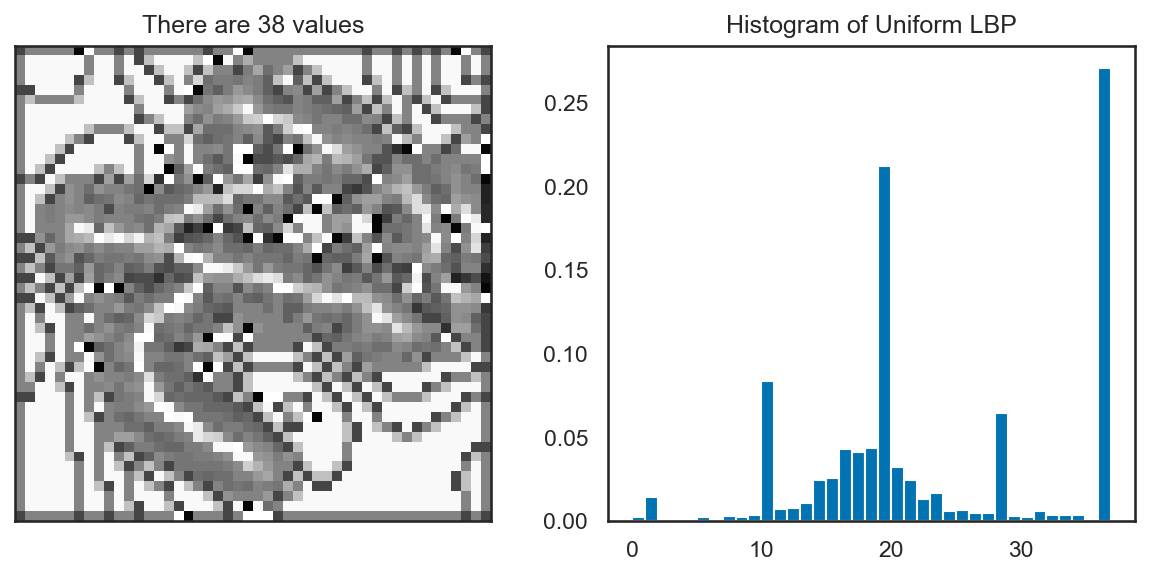

In [34]:
fig = plt.figure(figsize=(8, 4))
gs = GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.imshow(lbp, cmap="gray", interpolation=None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("There are {:d} values".format(int(np.max(lbp)) + 1))

ax2.hist(lbp.flatten(), bins=n_angles + 1, density=True)
ax2.set_title("Histogram of Uniform LBP")

plt.tight_layout()
plt.show()

すると、上記の通り、輝度のパターン数は36 + 2 = 38通りになることが分かる (画像の輝度が0から37の38通りになっている)。

また、画像の見た目から、文字がある部分の周りが一様に近いグレーで表現されており、回転に対してある程度の不変性を持っていそうなことも確認できる。

では、このUniform LBPを用いて、再度SVMによる文字の分類を試してみる。

In [35]:
def calc_ulbp_hist(x):
    lbp = local_binary_pattern(x, n_angles, 1.0, method="uniform")
    return np.histogram(lbp, bins=n_angles + 1, density=True)[0]


L = [calc_ulbp_hist(x.reshape((48, 48))) for x in tqdm(X)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [36]:
clf4 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf4.fit(L, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma=0.01, max_iter=200, tol=0.0001))])

In [37]:
# 訓練時の識別精度の確認
y_pred = clf4.predict(L)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("Uniform LBP: acc(train)={:.2f}%".format(acc_train))

Uniform LBP: acc(train)=14.35%


In [38]:
L_test = [calc_ulbp_hist(x.reshape((48, 48))) for x in tqdm(X_test)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [39]:
# テストデータに対する識別精度の計算
y_pred = clf4.predict(L_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Uniform LBP: acc(test)={:.2f}%".format(acc_test))

Uniform LBP: acc(test)=5.70%


すると、今度は訓練のスコアが悪化した代わりにテストスコアが上昇していることが分かる。しかしながら、これでも識別精度としては十分ではなく、回転対称性を考慮したことで精度が改善したとは言いがたい。

## Histogram of Oriented Gradient (HOG)

Histogram of Oriented Gradient (HOG)が広く知られるようになったのは2005年のことで、コンピュータ・ビジョンの国際会議であるCVPRで発表された論文{cite}`dalal2005histograms`がきっかけとなっている。

特にHOGは人物の全身といった特定の物体を見つける性能に優れており、一般物体認識や物体追跡等の多数の応用が生まれた。

HOGは画像を、互いに重ならない小さなパッチに分割して計算を行う。今回用いるひらがな画像は48×48の大きさなので、これを8×8のパッチに区切ってみる。

In [40]:
im = X[0].reshape((48, 48))
s = 8
patches = [im[y : y + 8, x : x + 8] for y in range(0, 48, s) for x in range(0, 48, s)]

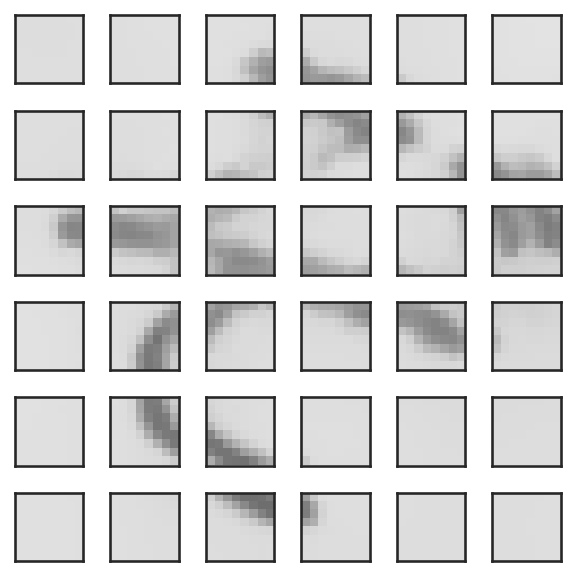

In [41]:
fig = plt.figure(figsize=(4, 4))
gs = GridSpec(6, 6, figure=fig)

for i in range(6):
    for j in range(6):
        ax = plt.subplot(gs[i, j])
        ax.imshow(patches[i * 6 + j], cmap="gray", vmin=0, vmax=255, interpolation=None)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()

次に、この各画像に対して、勾配強度と勾配方向を画素ごとに計算する。以下の実装では、x方向の勾配$d_x$とy方向の勾配$d_y$をSobelフィルタを使って求め、勾配強度$g$と勾配方向$\theta$を以下のように定義する。

$$
\begin{align}
    g &= \sqrt{ d_x^2 + d_y^2 } \\
    \theta &= \text{arctan} \frac{|d_y|}{d_x}
\end{align}
$$

なお、今回は向きのない方向 (= orientation, 0°から180°)を求めるため、上記の$\theta$の式において$d_y$に絶対値がかかっていることに注意すること。

今、各パッチは8×8の大きさなので、勾配強度と勾配方向がそれぞれ64個ずつ求まる。求まった勾配方向をいくつかの方向に量子化 (今回は20°刻みで9方向)し、ヒストグラムを作成する。各画素の方向に対応するビンには勾配強度を足して、ヒストグラムを計算する。

In [42]:
def calc_hist(p, n_angles=9):
    dx = cv2.Sobel(p, cv2.CV_8U, 1, 0)
    dy = cv2.Sobel(p, cv2.CV_8U, 0, 1)
    dx, dy = dx.astype("float32"), dy.astype("float32")

    g = np.sqrt(dx * dx + dy * dy)
    theta = 180.0 * np.arctan(np.abs(dy), dx) / np.pi
    t = (theta * n_angles / 180.0).astype("int32")

    h = np.zeros((n_angles), dtype="float32")
    for g_, t_ in zip(g.flatten(), t.flatten()):
        h[t_] += g_

    return h


n_angles = 9
hists = np.array([calc_hist(p, n_angles) for p in patches])
print(f"{hists.shape[0]:d} histograms with {hists.shape[1]:d} bins are obtained!")

36 histograms with 9 bins are obtained!


これにより6×6=36個のヒストグラムが求まった。ここで注意したいのは、これらのヒストグラムは勾配強度で計算されており、場所によって、ヒストグラムのスケールが異なっているという点である。

そこで、HOGでは、この6×6個のパッチを3×3のブロックごとに走査し、そのブロック内で連結したヒストグラムを正規化して用いる。今、勾配方向は9つに離散化されており、ブロック内のパッチが3×3=9個なので、1ブロックが持つヒストグラムの次元は9×9=81次元である。この81次元ベクトルをノルムが1になるように正規化しておく。

最終的に、81次元のヒストグラムが複数 (今回の場合は(6-3+1)×(6-3+1)=16個)求まるので、これらを連結して、画像の特徴量として用いる。

In [43]:
bs = 3
hists = hists.reshape((6, 6, -1))

# ブロックの取り出し
blocks = np.array(
    [hists[i : i + bs, j : j + bs] for i in range(6 - bs + 1) for j in range(6 - bs + 1)]
)
hog = blocks.reshape((-1, n_angles * bs * bs))

# ブロックごとのヒストグラムのノルムが1となるように正規化
hog = hog / np.sqrt(np.sum(hog * hog, axis=1, keepdims=True))
hog = hog.flatten()

以上をまとめると、HOGを計算する関数を以下のように定義できる。

In [44]:
def calc_hog(im):
    h, w = im.shape
    s = 8
    bs = 3
    n_angles = 9

    ph = h // s
    pw = w // s

    patches = [im[y : y + 8, x : x + 8] for y in range(0, h, s) for x in range(0, w, s)]
    hists = np.array([calc_hist(p, n_angles) for p in patches])
    hists = hists.reshape((ph, pw, -1))

    blocks = np.array(
        [hists[i : i + bs, j : j + bs] for i in range(ph - bs + 1) for j in range(pw - bs + 1)]
    )
    hog = blocks.reshape((-1, n_angles * bs * bs))

    hog = hog / (np.sqrt(np.sum(hog * hog, axis=1, keepdims=True)) + 1.0e-8)

    hog = hog.flatten()

    return hog

計算されたHOGを用いて、再度SVMを用いた分類を試してみる。

In [45]:
hogs = [calc_hog(x.reshape((48, 48))) for x in tqdm(X)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [46]:
clf5 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf5.fit(hogs, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma=0.01, max_iter=200, tol=0.0001))])

In [47]:
# 訓練時の識別精度の確認
y_pred = clf5.predict(hogs)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("HOG: acc(train)={:.2f}%".format(acc_train))

HOG: acc(train)=100.00%


In [48]:
hogs_test = [calc_hog(x.reshape((48, 48))) for x in tqdm(X_test)]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [49]:
# テストデータに対する識別精度の計算
y_pred = clf5.predict(hogs_test)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y_test)
print("Uniform LBP: acc(test)={:.2f}%".format(acc_test))

Uniform LBP: acc(test)=17.40%


## Bag of Visual Words

ここまでの特徴量は、画素の情報を元にして何らかのヒストグラムを得る、という方法であったが、続いては、画像に内在する画像の構造としての特徴を疎に抽出し、その特徴の集合をヒストグラム化する手法である**Bag of Visual Words** (BoVW, Bag of Featuresとも呼ばれる)について見ていく。


BoVWは、自然言語処理分野の**Bag of Words**から着想を得たもので、元のBag of Wordsは辞書に登録された各単語が文書の中に何回登場するかをヒストグラムとして表わした物である。

これに対してBag of Visual Wordsは、画像データセットから抽出された疎な特徴量の集合を単語の集まりだと見なす。ただし、画像から得られる特徴量は通常連続的であるため、特徴量をあらかじめクラスタ分割しておき、各特徴が属するクラスタを単語、クラスタの集まりを辞書と見なすことでBag of Wordsと同様の処理を可能にする。

以下では、画像に対する疎な特徴量の代表格である**Scale-Invariant Feature Transform** (SIFT)について、BoVWによる画像認識を試みる。

### Scale-Invariant Feature Transform (SIFT)

Scale-Invariant Feature Transform (SIFT)は、深層学習以前の画像認識における金字塔的な技術で、2000年前後にRoweらによって提案された{cite}`lowe1999object`, {cite}`lowe2004distinctive`。SIFTは画像の中に映り込む物体のスケールや回転に対して不変な特徴量を与えることができる。

SIFT特徴量の抽出処理は、少々複雑だが、大まかに分けて

- 特徴点の抽出
- 特徴点に対する特徴量の計算

の二つの処理に分けられる。

#### 特徴点の抽出

**特徴点の抽出**に置いては、Difference of Gaussian (DoG)というフィルタを用いて、特徴点のスケールを計算する。DoGは二つの異なる$\sigma_1$, $\sigma_2$ (ただし$\sigma_1 < \sigma_2$とする)を用いて、

$$
\text{DoG}(I) = G_{\sigma_1} \otimes I - G_{\sigma_2} \otimes I
$$

のように書ける。ただし$G_\sigma$は$\sigma$を標準偏差のパラメータとするGauss関数とする。例えば、以下のような画像になる。

In [50]:
im = cv2.resize(X[0].reshape((48, 48)), (256, 256))
im = (im / 255.0).astype("float32")
B1 = cv2.GaussianBlur(im, None, sigmaX=2.0)
B2 = cv2.GaussianBlur(im, None, sigmaX=4.0)
DoG = B1 - B2

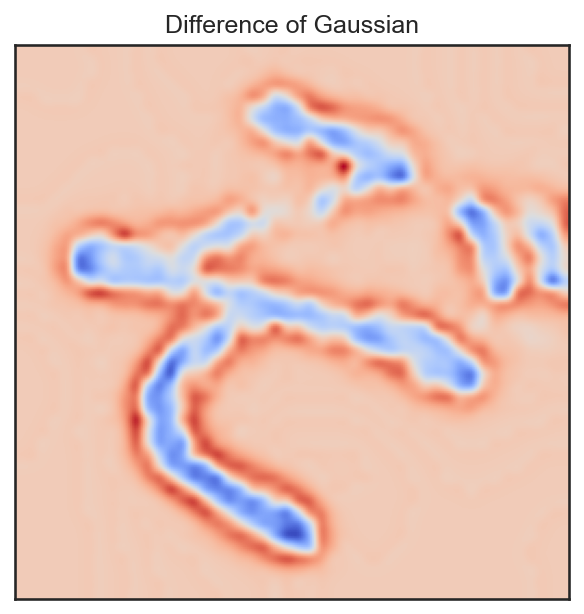

In [51]:
fig, ax = plt.subplots()
ax.imshow(DoG, cmap="coolwarm")
ax.set(title="Difference of Gaussian", xticks=[], yticks=[])
plt.show()

DoGの抽出を初期のパラメータ$\sigma$とスケールパラメータ$k$を用いて、$k^n\sigma$と$k^{n+1}\sigma$の間で$n=0, 1, 2, ...$の順で計算をしていく。この計算の過程でDoGの値が極値を取っていたら、そこをキーポイントの候補点として選ぶ。

選ばれた候補点が実際に特徴点になるかどうかは、DoG値が極値を取るスケールにおいて、DoG画像$D$のその画素における勾配情報を参考にして決定する。具体的には、画像$D$から有限差分を用いて、ヘッセ行列

$$
\mathbf{H} = \begin{bmatrix}
    D_{xx} & D_{xy} \\
    D_{yx} & D_{yy} 
\end{bmatrix}
$$

を計算し、$\mathbf{H}$のトレースと行列式の比、

$$
\frac{(\text{tr} \mathbf{H})^2}{\text{det}\mathbf{H}}
$$ (eq:ratio-tr-det)

の値が一定以下であれば、その候補特徴点を実際の特徴点として採用する。原論文では、閾値$t$として、

$$
t = \frac{(r + 1)^2}{r}
$$

という式を用いており、実装においては$r = 10$が用いられている。

以上の処理を、直感的に述べれば、前半のDoGの処理は画像中の勾配がある箇所を検出し、さらに、その勾配がどの程度の鮮鋭度を持つのかをスケールとして定量化しようとしている。

後半の処理、勾配の強さ (鮮鋭度は盛り上がりの角度であり、強さとは異なる)を見ており、$r = 10$とした場合に{cite}`(eq:ratio-tr-det)`が$t$より小さい、ということは、即ちヘッセ行列の2つの固有値の比が十分に大きい (10:1以上)であるかを検出している。

また、詳細は割愛するが、各特徴点には、勾配方向も同時に計算される。これは特徴点周りの画素に対して計算された勾配方向のヒストグラムの中で、いくつかの支配的な方向を特徴点に与えるものである。従って、各特徴点には2つ以上の勾配方向が割り当てられる可能性がある。

---

では、実際にOpenCVを用いて画像からSIFT特徴点と特徴量を計算する。以下では、特徴量の抽出結果を分かりやすくするために、48×48画素の画像を256×256画素にリサイズして特徴量を計算している。

In [52]:
# 画像のリサイズ
img = X[0].reshape((48, 48)).copy()
img = cv2.resize(img, (256, 256))

# 特徴量抽出器の準備
sift = cv2.SIFT_create()

# 特徴点の検出
keypoints = sift.detect(img)

前述の通り、SIFT特徴点の検出では、位置、スケール、勾配方向が計算されるので、それらを`cv2.drawKeypoints`で可視化してみる。

In [53]:
# 特徴点の描画
im_sift = cv2.drawKeypoints(
    img,
    keypoints,
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)

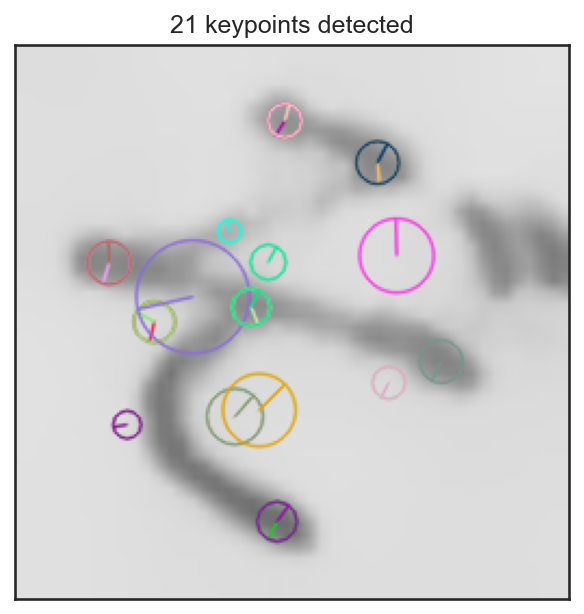

In [54]:
fig, ax = plt.subplots()
ax.imshow(im_sift)
ax.set(
    title="{:d} keypoints detected".format(len(keypoints)),
    xticks=[],
    yticks=[],
)
plt.show()

画像中では、円の中心が特徴点の位置を、円の大きさが特徴点のスケールを、そして円の中心から弧に向かって伸びる線分が勾配方向をそれぞれ表わしている。この際、文字の輪郭線のぼけ具合と円の大きさに相関があり、なおかつ勾配方向が輪郭線とおよそ直交する方向となっていることに注目してほしい。また、特徴点の中には2つ以上の勾配方向を持つものが存在することにも注目してほしい。

#### 特徴量の計算

特徴量の計算には、特徴点の計算で得られたスケールと方向を用いる。特徴量の計算には4×4のグリッドを用いるのだが、このグリッドの大きさを特徴点のスケールに応じて拡大縮小し、また勾配方向に応じてグリッドの向きを変更する。

このグリッドは上記の特徴点の可視化に現れる特徴点のスケールを表わす円に外接するように配置される。この円の大きさは、より具体的には極大のDoG値が検出された時に用いたGauss関数の$\sigma$の大きさに対応している。

グリッドの姿勢が計算できたら、4×4=16個のグリッドのそれぞれについて、特徴点の勾配方向ヒストグラムを45°刻みの8方向について計算する。この8個のビンの値を16個分連結することで、SIFT特徴量としての128次元ベクトルが得られる。

では、先ほど求めた特徴点に対して、OpenCVを用いて特徴量を計算する。

In [55]:
# 特徴量の計算
_, descriptors = sift.compute(img, keypoints)
print(descriptors.shape)

(21, 128)


このように特徴量 (`descriptors`)は「特徴点の数」×「特徴量の次元=128」で与えられることが確認できる。なお、特徴点の抽出と特徴量の計算は`sift.detectAndCompute`を用いることで同時に行うこともできる。

:::{admonition} 技術と特許
:class: note

新しい技術を開発して「特許」を取得すると、その技術の詳細を明細書として公開する代わりに、その技術に関わる権利を得ることができる。この特許は、一見、他の会社が当該の技術を使う障壁を上げており、技術の進歩にとってはマイナスな一面もある。

その一方、特許が取られていたがために、その技術を回避する目的で技術が進歩することもある。先に紹介したSIFTは当初2000年に特許が取得されたが、それに変わる技術として、Speeded-Up Robust Features (SURF) {cite}`bay2006surf`などの多くの特徴量が提案された (SURFは2006年に特許が取得されており、こちらはまだ特許が切れていない)。

このような例は他の分野でも、たびたび見られるもので、CT画像から物体の表面形状を抽出するMarching Cubes法も、その特許権を回避する目的で、ほとんど同等なMarching Tetrahedra法が開発されたりした。このように、物事には表と裏とがあるのが常である。
:::

### 特徴量のクラスタリング

BoVWを計算するためには、訓練データに含まれる全ての画像について、特徴量を計算し、それをクラスタリングする必要がある。

In [56]:
sift = cv2.SIFT_create()

vis_words = []
for x in tqdm(X):
    img = x.reshape((48, 48))
    _, descriptors = sift.detectAndCompute(img, None)
    vis_words.append(descriptors)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [57]:
all_vw = np.concatenate(vis_words, axis=0)
print("{:d} keypoints are detected!".format(len(all_vw)))

45153 keypoints are detected!


特徴量が得られたら、これをk平均法 (k-means法)によってクラスタリングする。今回は、簡単のためにscikit-learnの`KMeans`クラスを用いる。

In [58]:
from sklearn.cluster import KMeans

n_vw = 128
cls = KMeans(n_clusters=n_vw, n_init=4)
cls.fit(all_vw)

KMeans(n_clusters=128, n_init=4)

In [64]:
bovw = []
for vw in tqdm(vis_words):
    distances = cls.transform(vw)
    ids = np.argmin(distances, axis=1)
    hist = np.bincount(ids, minlength=n_vw) / len(ids)
    bovw.append(hist)

bovw = np.stack(bovw, axis=0)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [65]:
clf6 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf6.fit(bovw, y)

(2000, 128)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma=0.01, max_iter=200, tol=0.0001))])

In [66]:
# 訓練時の識別精度の確認
y_pred = clf6.predict(bovw)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("BoVW: acc(train)={:.2f}%".format(acc_train))

BoVW: acc(train)=98.70%


In [67]:
bovw = []
for x in tqdm(X_test):
    img = x.reshape((48, 48))
    _, vw = sift.detectAndCompute(img, None)
    distances = cls.transform(vw)
    ids = np.argmin(distances, axis=1)
    hist = np.bincount(ids, minlength=n_vw) / len(ids)
    bovw.append(hist)

bovw = np.stack(bovw, axis=0)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [68]:
# テスト時の識別精度の確認
y_pred = clf6.predict(bovw)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y)
print("BoVW: acc(test)={:.2f}%".format(acc_test))

BoVW: acc(test)=55.65%


### Gauss混合モデルを用いた改良

上記の例では、離散的に特徴量をクラスタ分割して、**最も近いクラスタ**に対して、各特量を割り当てることでヒストグラムを作成した。ただし、複数のクラスタの境界に特徴量が存在している可能性もあるため、その情報を捨てて、一番近いクラスタに特徴量を割り当てるのは、あまり適切とは言えない。

そこで、クラスタリングを用いる代わりに、特徴量の分布をGauss混合モデルによって近似しておき、各ガウス分布への寄与 (小数で表わされる)の和を画像の特徴ベクトルとして与えることを考える。

**Gauss混合モデル**とは、複数のGauss分布を和が1となるような正の重みによって重み付けたものであり、確率密度関数$P$が以下の形で書ける。

$$
P(\mathbf{x} | \boldsymbol\Theta) = \sum_{k=1}^K \pi_k \exp \left( - \frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^\top \boldsymbol\Sigma_k^{-1}  (\mathbf{x} - \boldsymbol{\mu}_k) \right)
$$ (eq:gaussian-mixture)

のように書ける。なお、この式で$\boldsymbol\Theta$はパラメータの集合 $\{ \pi_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k : k = 1, \ldots, K \}$を表わし、$\pi_k$, $\boldsymbol\mu_k$, $\boldsymbol\Sigma_k$は、それぞれ$k$番目のGauss分布に対する混合率、分布中心、共分散行列を表わす。

ガウス混合分布を用いると、とある特徴量$\mathbf{x}$が$k$個のGauss分布のそれぞれにどの程度の寄与率$\gamma_k(\mathbf{x})$を持つかを以下のように計算できる。

$$
\gamma_k(\mathbf{x}) = \frac{\pi_k \exp \left( - \frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^\top \boldsymbol\Sigma_k^{-1}  (\mathbf{x} - \boldsymbol{\mu}_k) \right) }{P(\mathbf{x})}
$$ (eq:membership)

これにより、特徴量$\mathbf{x}$に対する、特徴表現として、

$$
\boldsymbol\gamma = (\gamma_1(\mathbf{x}), \ldots, \gamma_K(\mathbf{x})^\top
$$

が得られる。これを画像に含まれる特徴量の集合$\mathcal{X} = \{ \mathbf{x}_i : i = 1, \ldots, N \}$に対して計算し、その平均値を画像の特徴ベクトルとする。

$$
\mathbf{f}(\mathcal{X}) = \frac{1}{N} \sum_{i=1}^N \boldsymbol\gamma(\mathbf{x}_i)
$$

In [73]:
from sklearn.mixture import GaussianMixture

n_vw = 128
gmm = GaussianMixture(n_components=n_vw, n_init=1, covariance_type="diag")
gmm.fit(all_vw)

GaussianMixture(covariance_type='diag', n_components=128)

In [75]:
bovw = []
for vw in tqdm(vis_words):
    probs = gmm.predict_proba(vw)
    bovw.append(probs.mean(axis=0))

bovw = np.stack(bovw, axis=0)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [76]:
clf7 = make_pipeline(
    StandardScaler(),
    SVC(**svc_params),
)
clf7.fit(bovw, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma=0.01, max_iter=200, tol=0.0001))])

In [80]:
# 訓練時の識別精度の確認
y_pred = clf7.predict(bovw)
acc_train = 100.0 * np.sum(y_pred == y) / len(y)
print("GMM-BoVW: acc(train)={:.2f}%".format(acc_train))

GMM-BoVW: acc(train)=98.40%


In [81]:
bovw = []
for x in tqdm(X_test):
    img = x.reshape((48, 48))
    _, vw = sift.detectAndCompute(img, None)
    probs = gmm.predict_proba(vw)
    bovw.append(probs.mean(axis=0))

bovw = np.stack(bovw, axis=0)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [82]:
# テスト時の識別精度の確認
y_pred = clf7.predict(bovw)
acc_test = 100.0 * np.sum(y_pred == y_test) / len(y)
print("GMM-BoVW: acc(test)={:.2f}%".format(acc_test))

GMM-BoVW: acc(test)=42.25%


### Fisherベクトルの利用

Fisherベクトルは、統計学等でも用いられるFisher情報量に基づく特徴表現である。とある確率密度分布が$\mathbf{x} \in \mathcal{X}$のパラメータ (母数)$\boldsymbol\Theta$に関する事後分布として $P(\mathbf{x} | \boldsymbol\Theta)$のように与えられる場合を考える。

Fisher情報量を求めるに当たり、Fisherベクトル$V(\mathbf{x}; \boldsymbol\Theta)$(スコア関数とも呼ばれる)を

$$
V(\mathbf{x}; \boldsymbol\Theta) = \nabla_{\boldsymbol\Theta} \log P(\mathbf{x} | \boldsymbol\Theta)
$$

のように表わす。なお、確率密度関数が連続関数であるとき、このFisherベクトルの平均はゼロベクトルになる。

Fisher情報量は上記のFisherベクトルの分散として与えられるが、この際、Fisherベクトルの平均が$\mathbf{0}$であることを用いると、Fisher情報量は以下のように与えられる。

$$
\mathbb{E}_{\mathbf{x} \sim \mathcal{X}}[ \nabla_{\boldsymbol\Theta} \log P(\mathbf{x} | \boldsymbol\Theta)) ]
$$

さて、ここで、$P(\mathbf{x} | \boldsymbol\Theta)$が{cite}`eq:gaussian-mixture`のガウス混合分布で与えられる場合を考える。以後、計算を簡単にするために、共分散行列は対角成分を$\boldsymbol\sigma_k$とする対角行列であるとする。

とあるパラメータ$\theta$に関する$\ln P(\mathbf{x} | \boldsymbol\Theta)$の微分は、

$$
\frac{\partial \log P(\mathbf{x}| \boldsymbol\Theta)}{\partial \theta} = \frac{1}{P(\mathbf{x} | \boldsymbol\Theta)} \frac{\partial P}{\partial\theta}
$$

のように書けることは言うまでもない。また、$P(\mathbf{x} | \boldsymbol\Theta)$の$\pi_k$, $\mu_{k,d}$, $\sigma_{k,d}$に関する偏微分はそれぞれ以下のように書ける。

$$
\begin{align}
\frac{\partial P(\mathbf{x} | \boldsymbol\Theta)}{\partial \pi_k}
&= \exp \left( -\frac{1}{2}(\mathbf{x} - \boldsymbol{\mu}_k)^\top \boldsymbol\Sigma_k^{-1}  (\mathbf{x} - \boldsymbol{\mu}_k) \right) = \frac{\mathcal{N}(\mathbf{x} | \boldsymbol\mu_{k}, \boldsymbol\sigma_k)}{\pi_k} \\
\frac{\partial P(\mathbf{x} | \boldsymbol\Theta)}{\partial \mu_{k,d}}
&= \pi_k \frac{x_d - \mu_{k,d}}{\sigma_d^2} \mathcal{N}(\mathbf{x} | \boldsymbol\mu_{k}, \boldsymbol\sigma_k) \\
\frac{\partial P(\mathbf{x} | \boldsymbol\Theta)}{\partial \sigma_{k,d}}
&= \pi_k \left( \frac{(x_d - \mu_{k,d})^2}{\sigma_d^3} \right) \mathcal{N}(\mathbf{x} | \boldsymbol\mu_{k}, \boldsymbol\sigma_k)
\end{align}
$$

したがって、{cite}`eq:membership`の寄与率$\gamma_k$を用いると、フィッシャーベクトルの各次元は以下のように書き直せる。

$$
\begin{align}
\frac{\partial \log P(\mathbf{x}| \boldsymbol\Theta)}{\partial \pi_k}
&= \frac{\gamma_k(\mathbf{x})}{\pi_k} \\
\frac{\partial \log P(\mathbf{x}| \boldsymbol\Theta)}{\partial \mu_{k,d}}
&= \gamma_k(\mathbf{x}) \frac{x_d - \mu_{k,d}}{\sigma_d^2} \\
\frac{\partial \log P(\mathbf{x}| \boldsymbol\Theta)}{\partial \sigma_{k,d}}
&= \gamma_k(\mathbf{x}) \frac{(x_d - \mu_{k,d})^2}{\sigma_d^3}
\end{align}
$$


## 練習問題

1. LBPとUniform LBPについて、文字の画像の輝度を増減したり、画像を回転させたときに、その特徴量がどのように変化するかを調べよ。

## 参考文献

```{bibliography}
:filter: docname in docnames
:style: alpha
```